# Imports

In [6]:
import requests
import json
import pandas as pd
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
from collections import defaultdict
import matplotlib.pyplot as plt

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oskay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\oskay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oskay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Activity 3

## 3.1 Sub-activity: Loading and pre-processing of text data

In [12]:
'''
This function is designed to allow me to conveniently view the content of files.
'''
def save_to_json(data, filename):
    with open(filename, "w") as file:
        json.dump(data, file, indent=4)

### Task1

In [15]:
'''
Since the Turing Award (Q185667) in Wikidata is not directly linked to its recipients, 
I can only find relevant information by searching for individual pages that contain the property P66 with a value of Q185667. 
About search: https://www.mediawiki.org/wiki/Help:Extension:WikibaseCirrusSearch
and https://agg-shashank.medium.com/an-introduction-to-using-wikidata-apis-a678ee6d2968
'''

'\nSince the Turing Award (Q185667) in Wikidata is not directly linked to its recipients, \nI can only find relevant information by searching for individual pages that contain the property P66 with a value of Q185667. \nAbout search: https://www.mediawiki.org/wiki/Help:Extension:WikibaseCirrusSearch\nand https://agg-shashank.medium.com/an-introduction-to-using-wikidata-apis-a678ee6d2968\n'

In [17]:
def get_turing_award_recipients():
    wikidata_api_url = "https://www.wikidata.org/w/api.php"
    params = {
        'action': 'query',
        'format': 'json',
        'list': 'search',
        'srnamespace': 0,
        'srsearch': 'haswbstatement:P166=Q185667',
        'srlimit': 100,
    }
    
    response = requests.get(wikidata_api_url, params = params)
    
    results = response.json().get('query', {}).get('search', [])
    title = [item['title'] for item in results]
    return title


In [19]:
'''        
#test area
data = get_turing_award_recipients()
#print(data)
'''

'        \n#test area\ndata = get_turing_award_recipients()\n#print(data)\n'

### Task2

In [22]:
def get_wikipedia_content(wikidata_id):
    try:
        wikidata_response = requests.get(
            "https://www.wikidata.org/w/api.php",
            params={
                'action': 'wbgetentities',
                'format': 'json',
                'ids': wikidata_id,
                'props': 'sitelinks',
            }
        )
        wikidata_response.raise_for_status()
        sitelinks = wikidata_response.json().get('entities', {}).get(wikidata_id, {}).get('sitelinks', {})
        
        if not sitelinks or 'enwiki' not in sitelinks:
            return None, 0 

        wikipedia_title = sitelinks['enwiki']['title']
        wikipedia_full_content_response = requests.get(
            "https://en.wikipedia.org/w/api.php",
            params={
                'action': 'query',
                'format': 'json',
                'prop': 'extracts',
                'explaintext': True,
                'titles': wikipedia_title,
            }
        )
        
        wikipedia_full_content_response.raise_for_status()
        pages = wikipedia_full_content_response.json().get('query', {}).get('pages', {})
        full_content = next(iter(pages.values()), {}).get('extract', None)

        if not full_content:
            return None, 0

        # divide paragraphs and count. it's for upcoming task
        paragraphs = [para.strip() for para in full_content.split("\n") if para.strip()]
        return paragraphs, len(paragraphs)
    except (requests.RequestException, KeyError, IndexError):
        return None, 0

In [24]:
'''
#test area
data1 = get_wikipedia_content("Q3572699")
save_to_json(data1, "Q3572699.json")
'''

'\n#test area\ndata1 = get_wikipedia_content("Q3572699")\nsave_to_json(data1, "Q3572699.json")\n'

### Task3

In [27]:
''' 
in tsak1 I set a index in wikidata
now  use this funtion to assert in the award winners dictionary
'''
def resolve_qid_to_label(ids):

    try:
        response = requests.get(
            "https://www.wikidata.org/w/api.php",
            params={
                'action': 'wbgetentities',
                'format': 'json',
                'ids': ids,
                'props': 'labels',
                'languages': 'en',
            }
        )
        response.raise_for_status()
        labels = response.json().get('entities', {}).get(ids, {}).get('labels', {})
        return labels.get('en', {}).get('value', ids)  
    except requests.RequestException:
        return ids

def get_claim_value(claims, property_id):

    claim_list = claims.get(property_id, [])
    if claim_list:
        mainsnak = claim_list[0].get('mainsnak', {})
        datavalue = mainsnak.get('datavalue', {})
        value = datavalue.get('value', {})
        if isinstance(value, dict) and 'time' in value:  
            return value.get('time')  
        if isinstance(value, dict) and 'id' in value:  
            return resolve_qid_to_label(value['id'])
        return value  
    return None

def get_wikidata_details(wikidata_id):
    try:
        response = requests.get(
            "https://www.wikidata.org/w/api.php",
            params={
                'action': 'wbgetentities',
                'format': 'json',
                'ids': wikidata_id,
                'props': 'labels|claims',
            }
        )
        response.raise_for_status()
        entity_data = response.json().get('entities', {}).get(wikidata_id, {})

        claims = entity_data.get('claims', {})
        return {
            "name": entity_data.get('labels', {}).get('en', {}).get('value', None),
            "gender": get_claim_value(claims, 'P21'),
            "birth_date": get_claim_value(claims, 'P569'),
            "birth_place": get_claim_value(claims, 'P19'),
            "employer": [
                get_claim_value({"P108": [claim]}, 'P108') for claim in claims.get('P108', [])
            ],
            "educated_at": [
                get_claim_value({"P69": [claim]}, 'P69') for claim in claims.get('P69', [])
            ],
        }
    except requests.RequestException:
        return None

def extract_intro_from_content_and_count(content):
    if not content or not isinstance(content, list):
        return None, 0 
    '''
    Because the content is separated by
    introduction
    == detail 1 ==
    ...

    I extract the content before the first == as the introduction.
    '''
    intro_paragraphs = []
    for para in content:
        if para.strip().startswith("==") and para.strip().endswith("=="):
            break
        intro_paragraphs.append(para)
    '''
    In ussual, the paragraph content I save is separate by " ", so
    Paragraph count: Each occurrence of a " " is considered a paragraph,
    but when I results, some recipients doesn't fit this codintion , so it may cause some problems.
    '''
    paragraph_count = len([para for para in intro_paragraphs if para.strip()])
    intro = " ".join(intro_paragraphs).strip() if intro_paragraphs else None
    return intro, paragraph_count

'''
insert the intro into award_winners dictionary
'''
def create_award_winners_with_intro_paragraphs(wikidata_ids):
    award_winners = {}

    for wikidata_id in wikidata_ids:
        details = get_wikidata_details(wikidata_id)
        if not details:
            continue

        content, _ = get_wikipedia_content(wikidata_id)
        intro, paragraph_count = extract_intro_from_content_and_count(content) if content else (None, 0)
        
        details["intro"] = intro
        details["paragraph_count"] = paragraph_count  

        award_winners[wikidata_id] = details

    return award_winners

turing_award_winners_ID = get_turing_award_recipients() 
award_winners = create_award_winners_with_intro_paragraphs(turing_award_winners_ID)
save_to_json(award_winners, "award_winners.json")

### Task4

In [29]:
'''
In task 3 will takes a lot of time,
so I save the award_winners as json files
'''

with open("award_winners.json", "r", encoding= "utf-8") as file:
    award_winners = json.load(file)

award_names = []
for wikidata_id, details in award_winners.items():
    award_names.append(details.get("name")) 


print("The name of all award winners in alphabetical order: \n{}".format(sorted(award_names)))

The name of all award winners in alphabetical order: 
['Adi Shamir', 'Alan Kay', 'Alan Perlis', 'Alfred Aho', 'Allen Newell', 'Amir Pnueli', 'Andrew Yao', 'Avi Wigderson', 'Barbara Liskov', 'Bob Kahn', 'Butler Lampson', 'Charles Bachman', 'Charles P. Thacker', 'Dana Scott', 'David A. Patterson', 'Dennis M. Ritchie', 'Donald Knuth', 'Douglas Engelbart', 'E. Allen Emerson', 'Edgar F. Codd', 'Edmund M. Clarke', 'Edsger W. Dijkstra', 'Edward Feigenbaum', 'Edwin Catmull', 'Fernando J. Corbató', 'Frances Allen', 'Fred Brooks', 'Geoffrey Hinton', 'Herbert Simon', 'Iosif Sifakis', 'Ivan Sutherland', 'Jack Dongarra', 'James H. Wilkinson', 'Jeffrey David Ullman', 'Jim Gray', 'John Backus', 'John Cocke', 'John Edward Hopcroft', 'John L. Hennessy', 'John McCarthy', 'Judea Pearl', 'Juris Hartmanis', 'Ken Thompson', 'Kenneth E. Iverson', 'Kristen Nygaard', 'Leonard Adleman', 'Leslie Lamport', 'Leslie Valiant', 'Manuel Blum', 'Martin Edward Hellman', 'Marvin Minsky', 'Maurice Wilkes', 'Michael O. Rab

### Task5

In [31]:
#(a)
winner_data = []
for wikidata_id, details in award_winners.items():
    row = {
        "winner_name": details.get("name"),
        "intro": details.get("intro"),
        "count_words": None,         
        "count_sentences": None,     
        "count_paragraphs": details.get("paragraph_count", 0),  # 使用有效段落數
        "common_words": None
    }
    winner_data.append(row)

award_winners_intro = pd.DataFrame(winner_data)

#test
#print(award_winners_intro)

In [32]:
#(b)
for index, row in award_winners_intro.iterrows():
    intro_text = row['intro'] if row['intro'] else ""  

    # count words
    word_count = len(intro_text.split())

    # count ssetence number: separate by .
    sentence_count = len([sentence for sentence in intro_text.split('.') if sentence.strip()])

    # count the frequent words
    words = re.findall(r'\b\w+\b', intro_text.lower())
    common_words = [word for word, _ in Counter(words).most_common(10)] 

    # insert the DataFrame
    award_winners_intro.at[index, 'count_words'] = word_count
    award_winners_intro.at[index, 'count_sentences'] = sentence_count
    award_winners_intro.at[index, 'common_words'] = ", ".join(common_words)




In [33]:
#(c) delete the stop words and punctuation
stop_words = set(stopwords.words('english'))

for index, row in award_winners_intro.iterrows():
    intro_text = row['intro'] if row['intro'] else ""


    words = re.findall(r'\b\w+\b', intro_text.lower())


    filtered_words = [word for word in words if word not in stop_words and word not in string.punctuation]


    common_words_after_preprocessing = [word for word, _ in Counter(filtered_words).most_common(10)]


    award_winners_intro.at[index, 'common_words_after_preprocessing'] = ", ".join(common_words_after_preprocessing)




In [34]:
#(d)

print(award_winners_intro.head(10))

       winner_name                                              intro  \
0  Tim Berners-Lee  Sir Timothy John Berners-Lee (born 8 June 1955...   
1    Yoshua Bengio  Yoshua Bengio  (born March 5, 1964) is a Canad...   
2     Donald Knuth  Donald Ervin Knuth ( kə-NOOTH; born January 10...   
3  Geoffrey Hinton  Geoffrey Everest Hinton (born 6 December 1947)...   
4  Richard M. Karp  Richard Manning Karp (born January 3, 1935) is...   
5    Robert Tarjan  Robert Endre Tarjan (born April 30, 1948) is a...   
6        Vint Cerf  Vinton Gray Cerf (; born June 23, 1943) is an ...   
7      Judea Pearl  Judea Pearl (born September 4, 1936) is an Isr...   
8    Herbert Simon  Herbert Alexander Simon (June 15, 1916 – Febru...   
9    Marvin Minsky  Marvin Lee Minsky (August 9, 1927 – January 24...   

  count_words count_sentences  count_paragraphs  \
0         306              14                 4   
1         130               8                 2   
2         188              10              

## 3.2 Sub-activity: Applying NLP operations on the corpus

### 3.2.1 Stemming

#### Task 6 

In [38]:
#(a)remove stopwords and punctuation from all intros
intro_words = []

for intro in award_winners_intro['intro']:
    if intro:
        words = re.findall(r'\b\w+\b', intro.lower())
        filtered_words = [word for word in words if word not in stop_words and word not in string.punctuation]
        intro_words.extend(filtered_words)

In [39]:
# (b) 
unique_intro_words = set(intro_words)
print("The number of unique intro_words:", len(unique_intro_words) )

The number of unique intro_words: 1708


In [40]:
# (c) Apply the PorterStemmer
ps = PorterStemmer()
stemmed_words = [ps.stem(word) for word in intro_words]
unique_words_after_ps = set(stemmed_words)

print("The number of unique words after poster stemming:", len(unique_words_after_ps))

The number of unique words after poster stemming: 1476


#### Task7

In [42]:
#Apply SnowballStemmer
snowball_stemmer = SnowballStemmer(language='english')
# process
snowball_stemmed_words = [snowball_stemmer.stem(word) for word in intro_words]
unique_words_after_snowball = set(snowball_stemmed_words)


print("The number of unique intro_words:", len(unique_intro_words) )
print("The number of unique words after Snowball stemming:", len(unique_words_after_snowball))


The number of unique intro_words: 1708
The number of unique words after Snowball stemming: 1473


### 3.2.2 Lemmatization

#### Task 8

In [45]:
#Apply WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
#process
lemmatized_words = [lemmatizer.lemmatize(word) for word in intro_words]
unique_words_after_lemmatization = set(lemmatized_words)
print("The number of unique intro_words:", len(unique_intro_words))
print("The number of unique intro_words after lemmatization:", len(unique_words_after_lemmatization))


The number of unique intro_words: 1708
The number of unique intro_words after lemmatization: 1633


### 3.2.3 Finding synonyms and antonyms

In [47]:
# Reference: https://visharma1.medium.com/python-synonyms-and-antonyms-6124cabe953e

#### Task4

In [49]:
# (a) 
award_winners_intro["synonyms"] = None
award_winners_intro["antonyms"] = None

In [50]:
#(b) synonyms

def get_synonyms(reference_words):
    synonyms = set()
    for word in reference_words:
        for syn in wordnet.synsets(word): 
            for lemma in syn.lemmas():
                if lemma.name() in reference_words:  
                    synonyms.add(lemma.name())
    return list(synonyms)

award_winners_intro['synonyms'] = award_winners_intro['common_words_after_preprocessing'].apply(
    lambda x: get_synonyms(x.split(", ")) if isinstance(x, str) else []
)

In [51]:
#(c)antonyms

def get_antonyms(reference_words):
    antonyms = set()
    for word in reference_words:  
        for syn in wordnet.synsets(word): 
            for lemma in syn.lemmas():
                if lemma.antonyms():
                    antonyms.add(lemma.antonyms()[0].name()) 
    return list(antonyms)

#when i put 'common_words_after_preprocessing' it will output nothing,  so I put synonyms
award_winners_intro['antonyms'] = award_winners_intro['synonyms'].apply(
    lambda x: get_antonyms(x) if isinstance(x, list) else []
)


In [52]:
#(d) output

print(award_winners_intro.head(10))

       winner_name                                              intro  \
0  Tim Berners-Lee  Sir Timothy John Berners-Lee (born 8 June 1955...   
1    Yoshua Bengio  Yoshua Bengio  (born March 5, 1964) is a Canad...   
2     Donald Knuth  Donald Ervin Knuth ( kə-NOOTH; born January 10...   
3  Geoffrey Hinton  Geoffrey Everest Hinton (born 6 December 1947)...   
4  Richard M. Karp  Richard Manning Karp (born January 3, 1935) is...   
5    Robert Tarjan  Robert Endre Tarjan (born April 30, 1948) is a...   
6        Vint Cerf  Vinton Gray Cerf (; born June 23, 1943) is an ...   
7      Judea Pearl  Judea Pearl (born September 4, 1936) is an Isr...   
8    Herbert Simon  Herbert Alexander Simon (June 15, 1916 – Febru...   
9    Marvin Minsky  Marvin Lee Minsky (August 9, 1927 – January 24...   

  count_words count_sentences  count_paragraphs  \
0         306              14                 4   
1         130               8                 2   
2         188              10              

### 3.2.4 Bigrams and trigrams

#### Task10

In [55]:
#tokenize the intro
intros_tokenize = []
for intro in award_winners_intro["intro"]:
    tokens = word_tokenize(intro)
    intros_tokenize.append(tokens)
#test
#print(intros_tokenize)

#### Task11

In [57]:
# bigrams 
def get_bigrams_frequency(intros_tokenize):
    stop_words = set(stopwords.words('english'))
    bigram_freq = defaultdict(int)

    for tokens in intros_tokenize:
        filtered_tokens = [
            word.lower() for word in tokens 
            if word not in stop_words 
            and word not in string.punctuation 
            and word != "=="
        ]
        bigram_list = list(bigrams(filtered_tokens))
        
        for bigram in bigram_list:
            bigram_freq[bigram] += 1
    
    return bigram_freq

#### Task 12

In [59]:
winner_bigrams = {}
winner_bigrams = get_bigrams_frequency(intros_tokenize)

#### Task13

In [61]:
print(" The TOP 15 most frequently occurring bigrams：")
for bigram, freq in sorted(winner_bigrams.items(), key=lambda item: item[1], reverse=True)[:15]:
    print(f"{bigram}: {freq}")

 The TOP 15 most frequently occurring bigrams：
('computer', 'scientist'): 62
('turing', 'award'): 62
('computer', 'science'): 51
('american', 'computer'): 33
('artificial', 'intelligence'): 15
('he', 'also'): 15
('he', 'received'): 12
('received', 'turing'): 12
('best', 'known'): 11
('programming', 'language'): 11
('programming', 'languages'): 10
('professor', 'emeritus'): 9
('national', 'academy'): 9
('deep', 'learning'): 8
('professor', 'computer'): 8


## 3.3 Sub-section: Visualisation

### 3.3.1 Barplots

#### Task 14

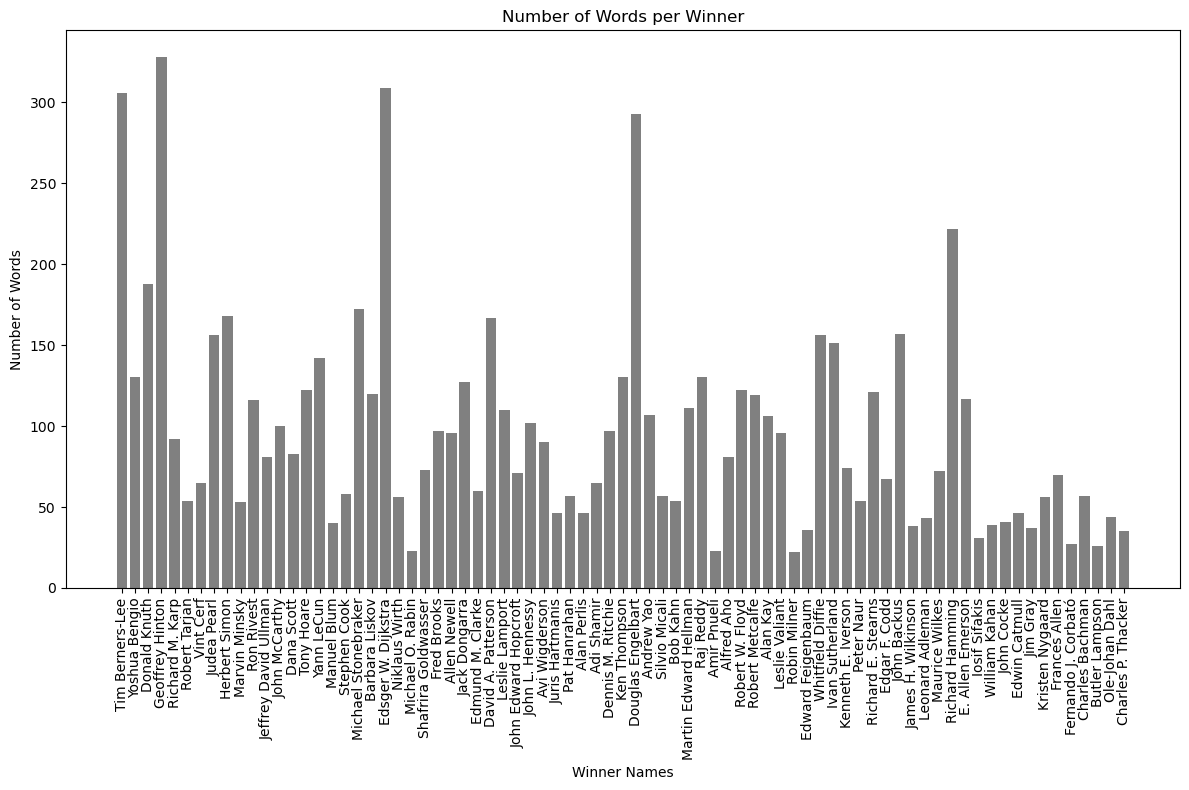

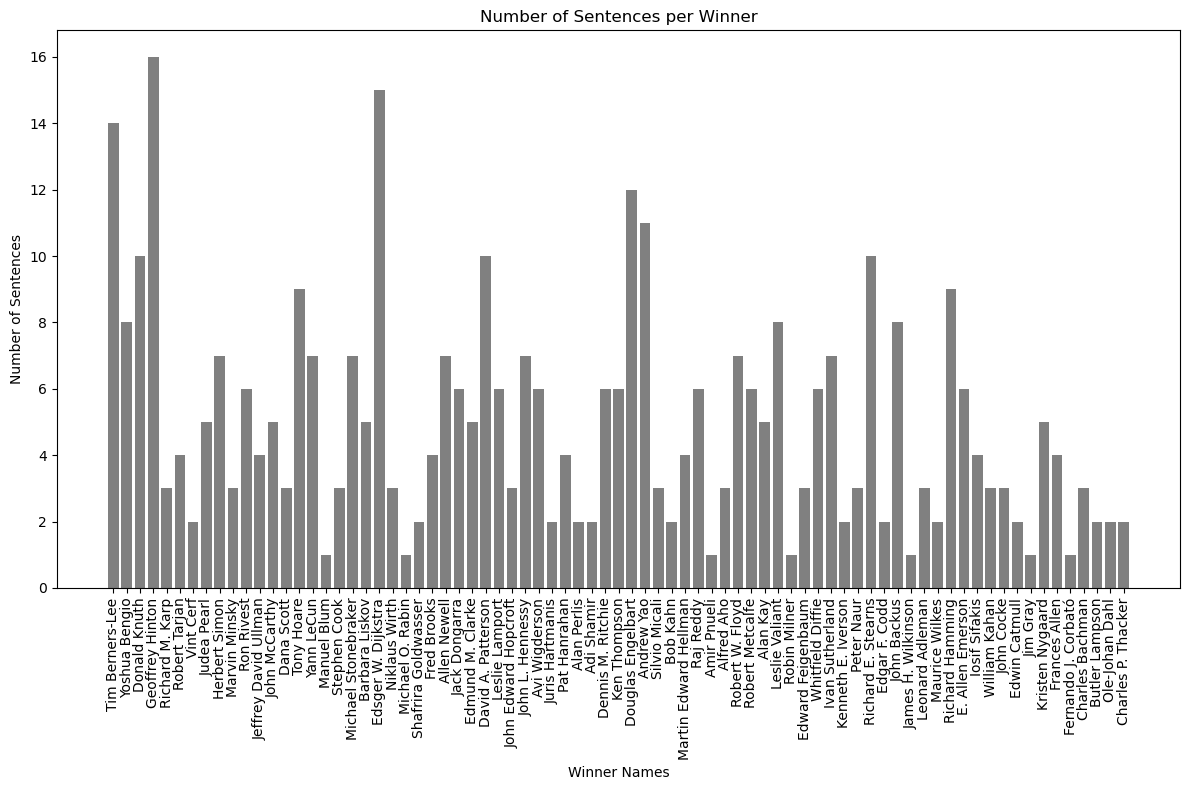

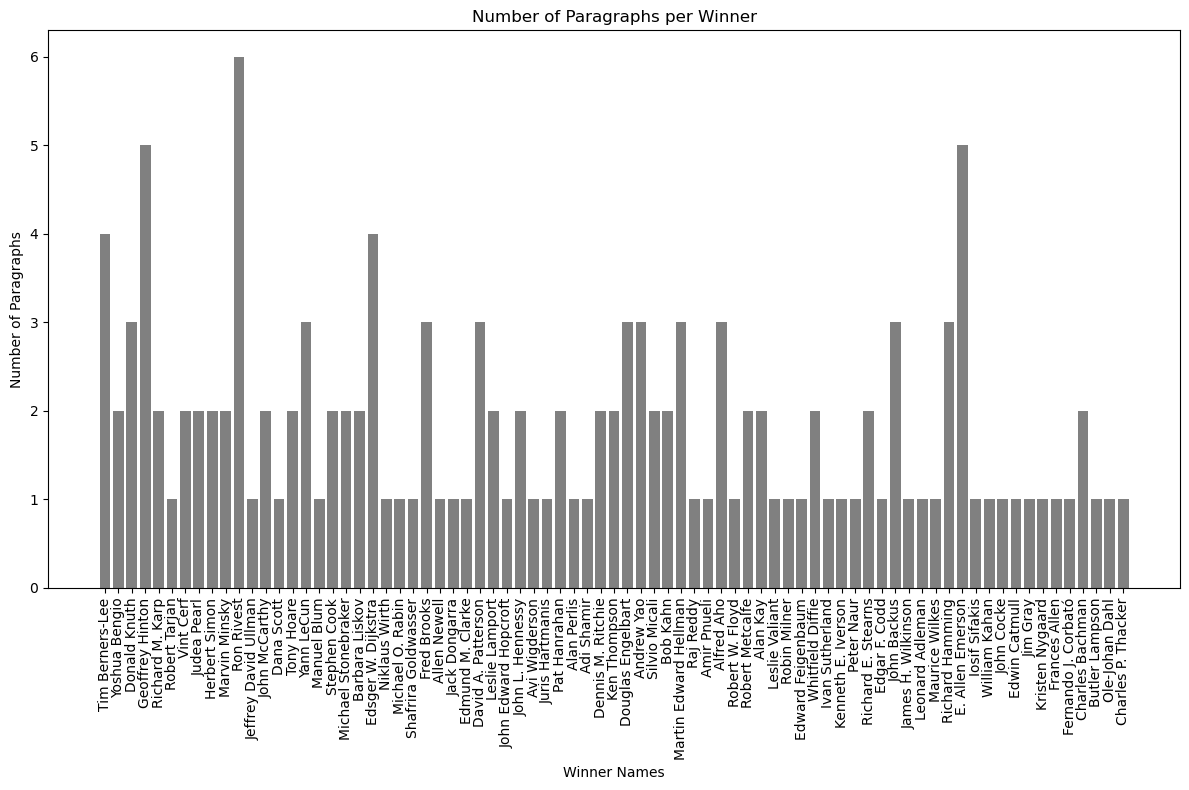

In [65]:
winner_names = award_winners_intro['winner_name']
word_counts = award_winners_intro['count_words']
sentence_counts = award_winners_intro['count_sentences']
paragraph_counts = award_winners_intro['count_paragraphs']

# Barplot 1: Number of Words per Winner
plt.figure(figsize=(12, 8))
plt.bar(winner_names, word_counts, color='gray')
plt.title('Number of Words per Winner')
plt.xlabel('Winner Names')
plt.ylabel('Number of Words')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Barplot 2: Number of Sentences per Winner
plt.figure(figsize=(12, 8))
plt.bar(winner_names, sentence_counts, color='gray')
plt.title('Number of Sentences per Winner')
plt.xlabel('Winner Names')
plt.ylabel('Number of Sentences')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Barplot 3: Number of Paragraphs per Winner
plt.figure(figsize=(12, 8))
plt.bar(winner_names, paragraph_counts, color='gray')
plt.title('Number of Paragraphs per Winner')
plt.xlabel('Winner Names')
plt.ylabel('Number of Paragraphs')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Task 15

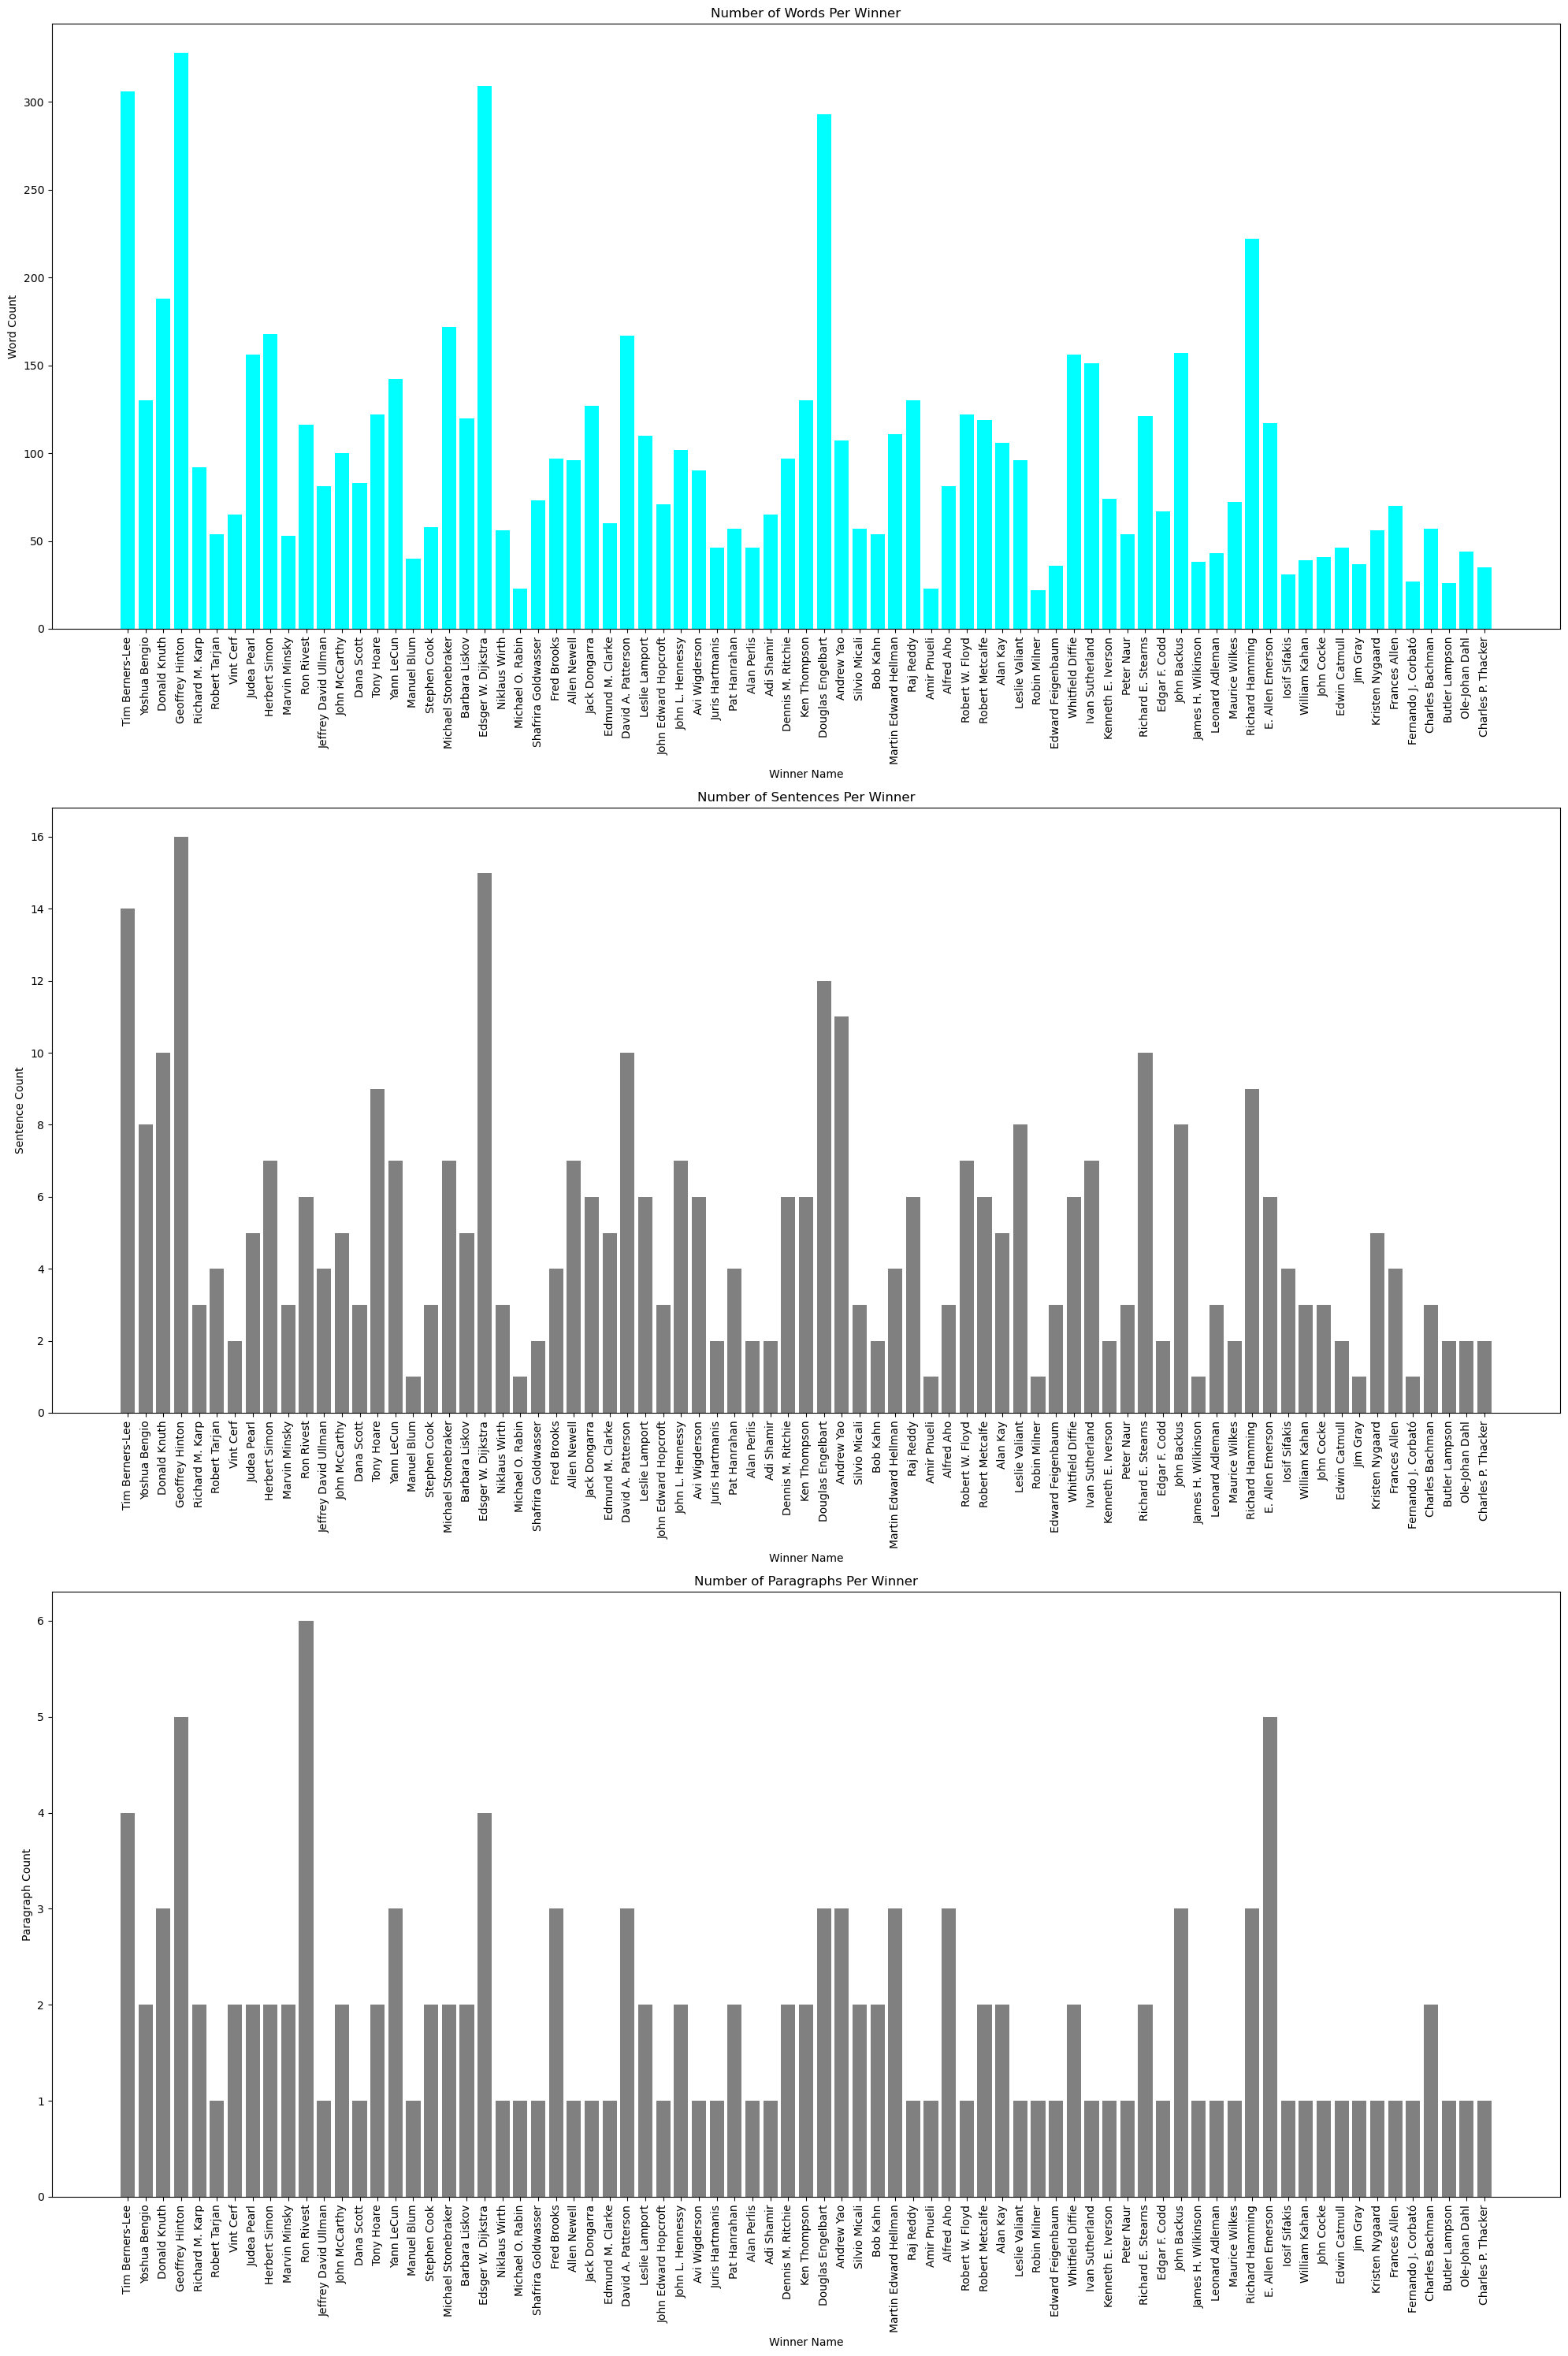

In [67]:
fig, axes = plt.subplots(3, 1, figsize=(20, 30))

axes[0].bar(winner_names, word_counts, color='cyan')
axes[0].set_title('Number of Words Per Winner')
axes[0].set_xlabel('Winner Name')
axes[0].set_ylabel('Word Count')
axes[0].tick_params(axis='x', rotation=90)

axes[1].bar(winner_names, sentence_counts, color='gray')
axes[1].set_title('Number of Sentences Per Winner')
axes[1].set_xlabel('Winner Name')
axes[1].set_ylabel('Sentence Count')
axes[1].tick_params(axis='x', rotation=90)

axes[2].bar(winner_names, paragraph_counts, color='gray')
axes[2].set_title('Number of Paragraphs Per Winner')
axes[2].set_xlabel('Winner Name')
axes[2].set_ylabel('Paragraph Count')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

#### Task16

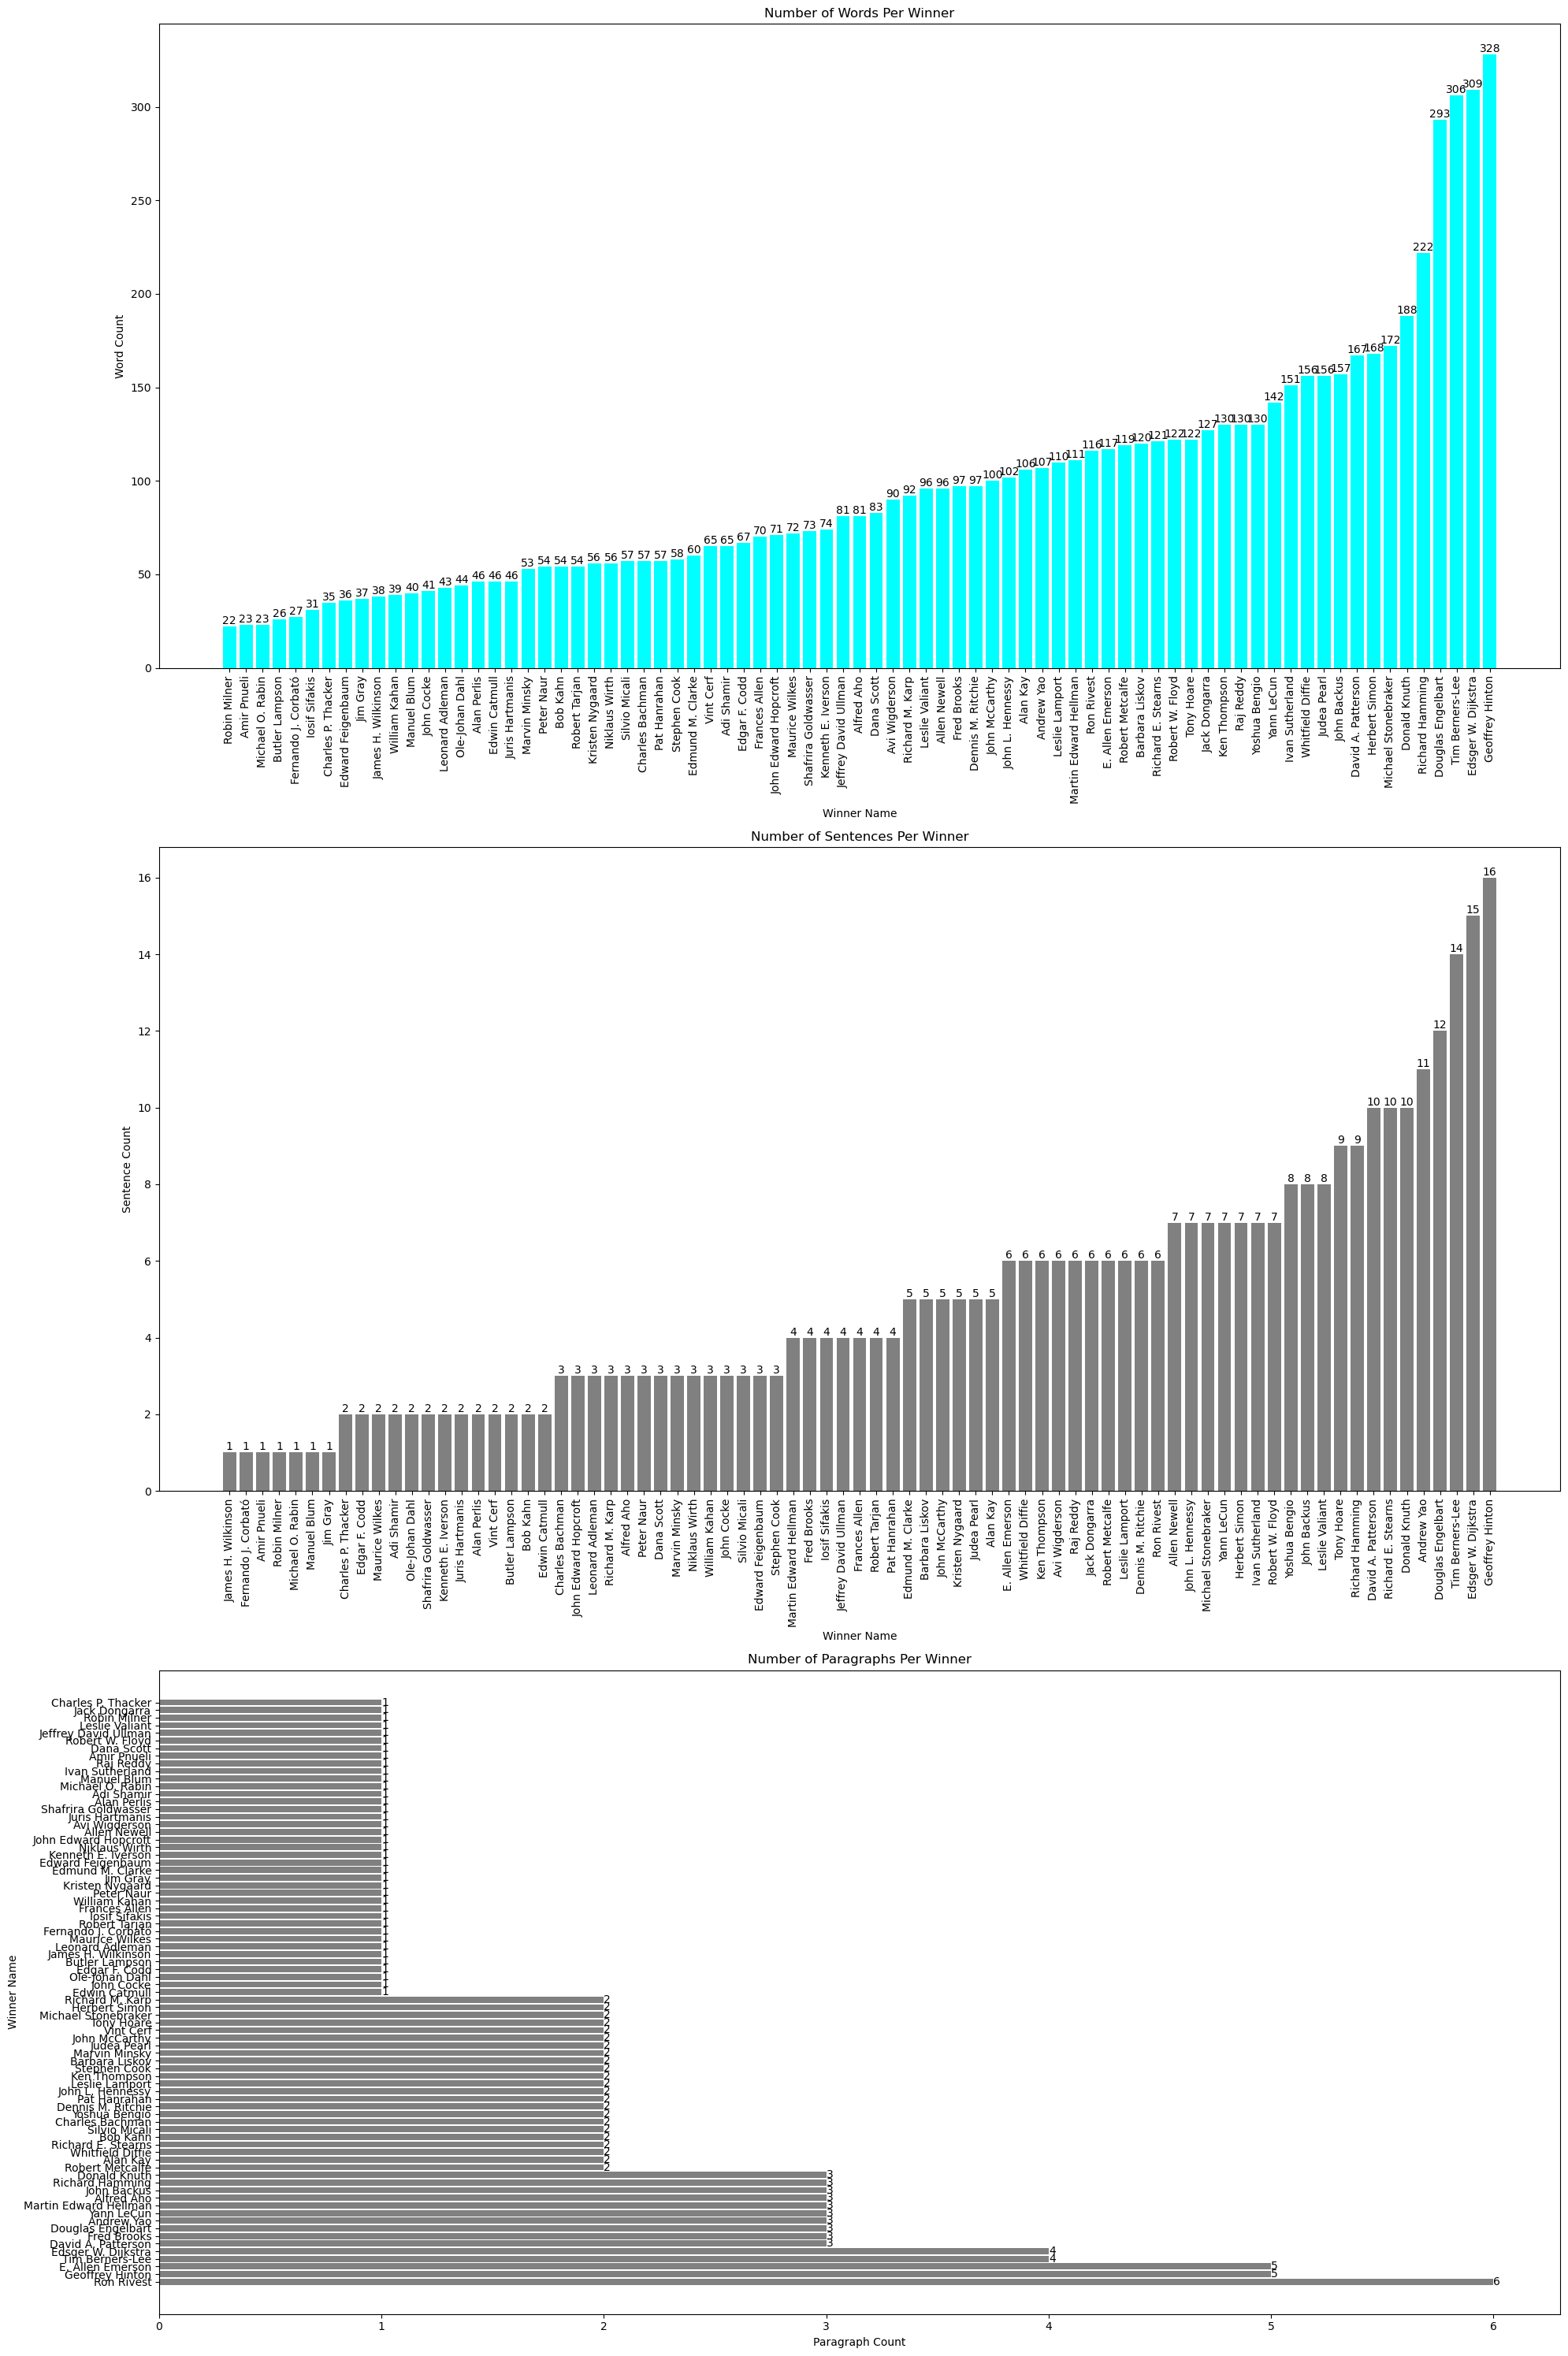

In [93]:
df_sorted_words = award_winners_intro.sort_values(by='count_words')
df_sorted_sentences = award_winners_intro.sort_values(by='count_sentences')
df_sorted_paragraphs = award_winners_intro.sort_values(by='count_paragraphs', ascending = False) #If ascending = True ,than the result is not ascending order from top to bottom


fig, axes = plt.subplots(3, 1, figsize=(20, 30))


bars1 = axes[0].bar(df_sorted_words['winner_name'], df_sorted_words['count_words'], color='cyan')
axes[0].set_title('Number of Words Per Winner')
axes[0].set_xlabel('Winner Name')
axes[0].set_ylabel('Word Count')
axes[0].tick_params(axis='x', rotation=90)
axes[0].bar_label(bars1)


bars2 = axes[1].bar(df_sorted_sentences['winner_name'], df_sorted_sentences['count_sentences'], color='gray')
axes[1].set_title('Number of Sentences Per Winner')
axes[1].set_xlabel('Winner Name')
axes[1].set_ylabel('Sentence Count')
axes[1].tick_params(axis='x', rotation=90)
axes[1].bar_label(bars2)


bars3 = axes[2].barh(df_sorted_paragraphs['winner_name'], df_sorted_paragraphs['count_paragraphs'], color='gray')
axes[2].set_title('Number of Paragraphs Per Winner')
axes[2].set_xlabel('Paragraph Count')
axes[2].set_ylabel('Winner Name')
axes[2].bar_label(bars3)

plt.tight_layout()
plt.show()